### Kernel Density Estimation

In [7]:
from Utilities.utils import read_data

In [8]:
url = 'https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt'
raw, _ = read_data(url)

c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ML\GammaRayBursts\Utilities\utils.py:21: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  raw = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [125]:
fluence, fluence_err = zip(*[(float(a), float(b)) for a, b in zip(raw[9], raw[10]) 
                                           if a != '-999' and b != '-999' 
                                           and float(b)!=0 and float(a)!=0] )

In [126]:
import numpy as np

In [127]:
erg_to_KeV = 624150907446.1*1e-3

In [128]:
fluence = np.log10(np.array(fluence)*erg_to_KeV)

In [129]:
import matplotlib.pyplot as plt
from Utilities import plot_settings

Text(0, 0.5, 'Density')

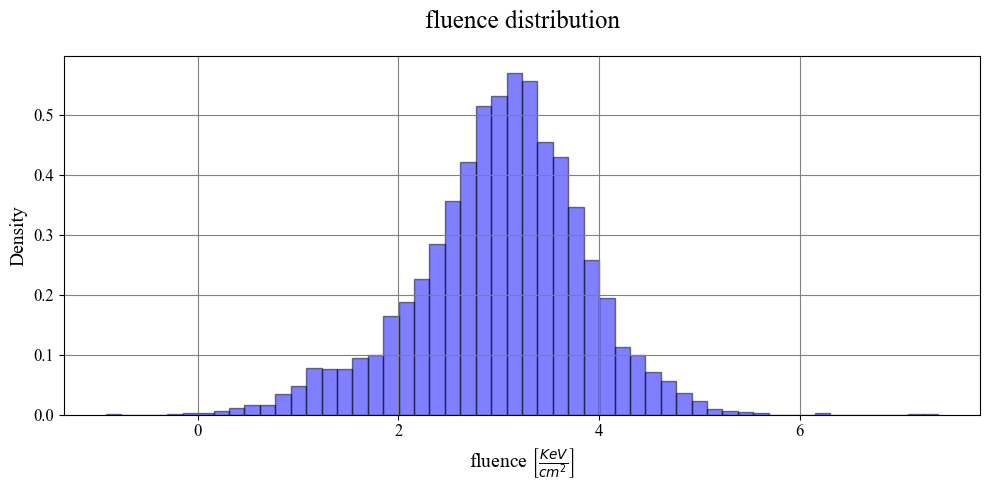

In [131]:
fluencec, fluenceb, _ = plt.hist(fluence, bins='scott', density=True, 
                         histtype='barstacked', edgecolor='black', color='blue', alpha=0.5) 
plt.title('fluence distribution')
plt.xlabel(r'fluence $\left[\frac{KeV}{cm^2}\right]$')
plt.ylabel('Density')

In [132]:
from sklearn.neighbors import KernelDensity

In [133]:
import numpy as np

In [134]:
X = fluence.reshape((-1,1))

In [135]:
bandwidths = np.linspace(0.1,1,10)

In [136]:
from Utilities.utils import KDE_LOO, cross_validation_LOO

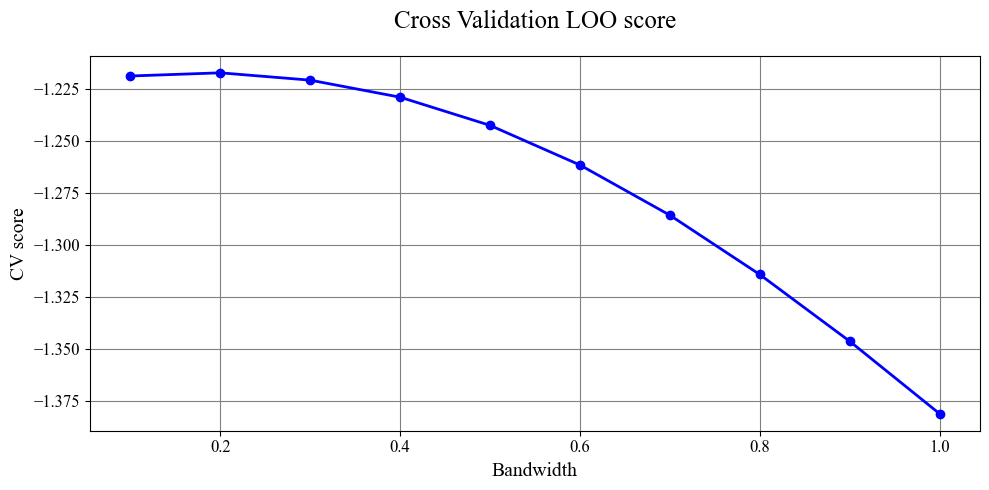

In [137]:
scores, best, best_bw = cross_validation_LOO(X, bandwidths, True)

In [138]:
xgrid = np.linspace(np.array(fluence).min(), np.array(fluence).max(),1000)

def kde_sklearn(data, bandwidth, kernel="gaussian"):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf), kde_skl

In [139]:
pdf, kde = kde_sklearn(np.array(fluence), bandwidths[best_bw])

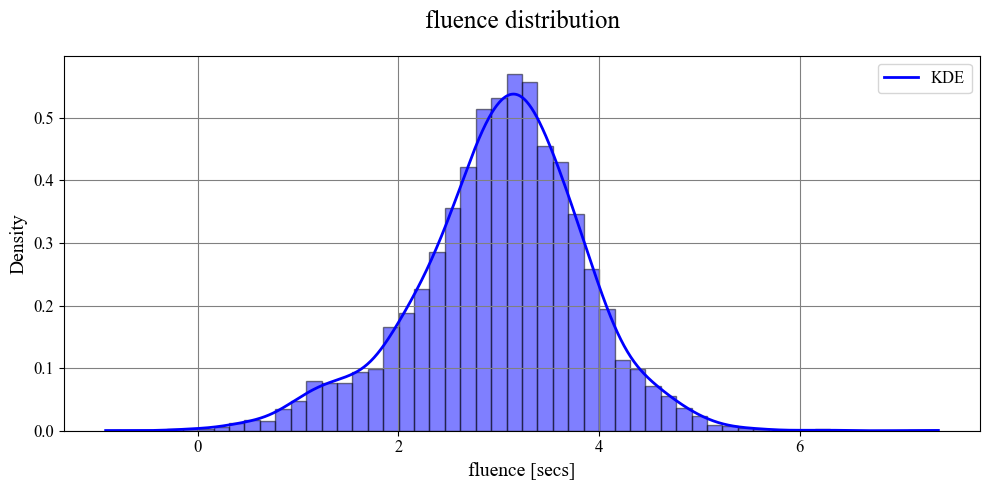

In [140]:
plt.plot(xgrid, pdf, color='blue', linewidth=2, label='KDE')
counts, bins, _ = plt.hist(fluence, bins='scott', density=True, histtype='barstacked', edgecolor='black', color='blue', alpha=0.5) 
plt.title('fluence distribution')
plt.xlabel('fluence [secs]')
plt.ylabel('Density')
plt.legend()

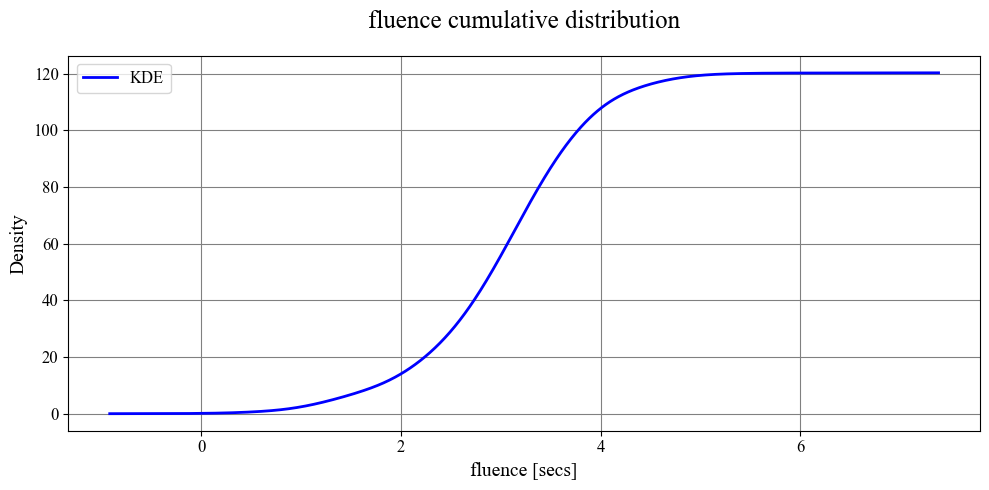

In [141]:
plt.plot(xgrid, np.cumsum(pdf), color='blue', linewidth=2, label='KDE')
plt.title('fluence cumulative distribution')
plt.xlabel('fluence [secs]')
plt.ylabel('Density')
plt.legend()

In [142]:
import scipy.stats

In [143]:
print('fluence Mean: ',fluence.mean())
print('fluence Std: ', fluence.std())
print('fluence mode:', scipy.stats.mode(fluence).mode)
print('fluence max: ', fluence.max())
print('fluence min: ', fluence.min())

fluence Mean:  3.0137537789781437
fluence Std:  0.8357049633305809
fluence mode: 2.2102629542358487
fluence max:  7.384524098680535
fluence min:  -0.9187707139231828


## Gaussian Mixture

In [144]:
from sklearn.mixture import GaussianMixture

In [145]:
ns = np.arange(1,20,1)

In [146]:
aic = np.zeros_like(ns)
bic = np.zeros_like(ns)
for n in ns:
    GM = GaussianMixture(n_components=n)
    GM.fit(X)
    aic[n-min(ns)] = GM.aic(X)
    bic[n-min(ns)] = GM.bic(X)

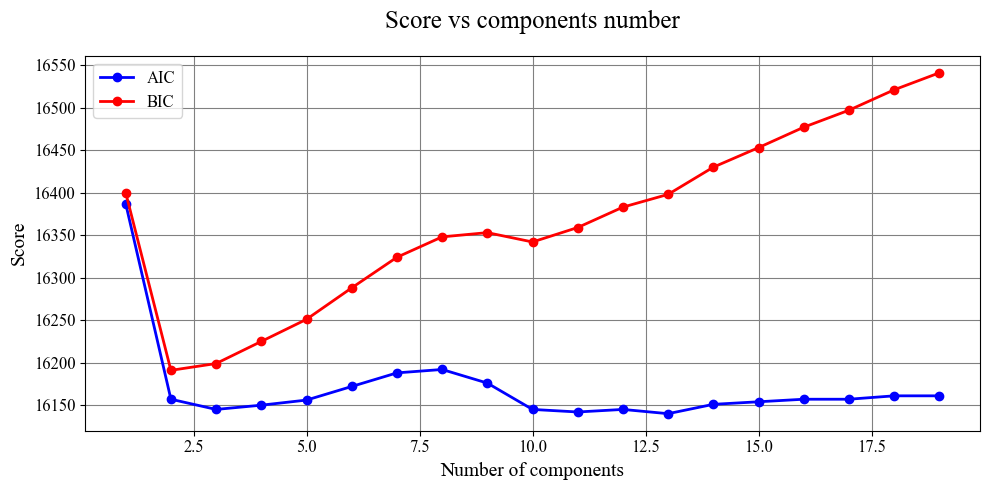

In [147]:
plt.plot(ns, aic, marker='o', color='blue', linewidth=2, label='AIC')
plt.plot(ns, bic, marker='o', color='red', linewidth=2, label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('Score vs components number')
plt.legend()

In [148]:
GM = GaussianMixture(n_components=3)
GM.fit(X)

GaussianMixture(n_components=3)

In [149]:
x = np.linspace(X.min() - 0.5, X.max() + 0.5, 1000).reshape(-1, 1)

In [150]:
from scipy.stats import norm

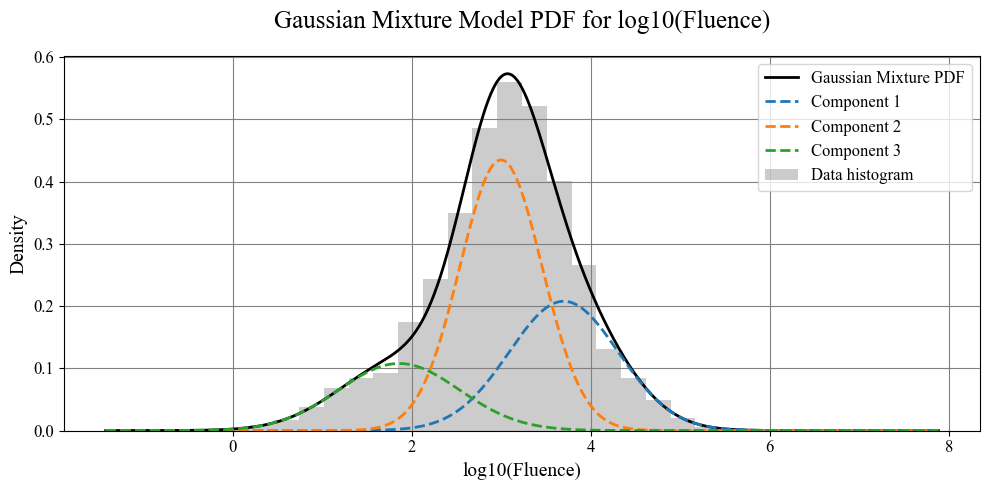

In [151]:
# Compute the weighted sum of PDFs from each Gaussian component
logprob = GM.score_samples(x)
pdf = np.exp(logprob)

# Plot the overall PDF
plt.plot(x, pdf, label='Gaussian Mixture PDF', color='black')

# Optionally plot the individual Gaussians
for i in range(GM.n_components):
    mean = GM.means_[i, 0]
    std = np.sqrt(GM.covariances_[i, 0, 0])
    weight = GM.weights_[i]
    component_pdf = weight * norm.pdf(x, mean, std)
    plt.plot(x, component_pdf, '--', label=f'Component {i+1}')

# Add original data histogram for context
plt.hist(X, bins=30, density=True, alpha=0.4, color='gray', label='Data histogram')

plt.xlabel('log10(Fluence)')
plt.ylabel('Density')
plt.title('Gaussian Mixture Model PDF for log10(Fluence)')
plt.legend()

In [152]:
for i in range(GM.n_components):
    print(f'Fluence Centroid {i}: {np.power(10,GM.means_[i, 0]):.3} +/- {np.sqrt(GM.covariances_[i, 0, 0])*np.power(10,GM.means_[i, 0]):.3} KeV/cm^2')

Fluence Centroid 0: 5e+03 +/- 3.05e+03 KeV/cm^2
Fluence Centroid 1: 9.96e+02 +/- 4.57e+02 KeV/cm^2
Fluence Centroid 2: 72.4 +/- 48.8 KeV/cm^2


In [154]:
import pymc as pm

In [ ]:
sigma_obs = np.array(fluence_err).reshape((-1,1))  # measurement errors (same shape)

K = 3  # number of mixture components
n = len(X)

with pm.Model() as model:
    # Mixture weights
    weights = pm.Dirichlet('weights', a=np.ones(K))

    # Component means and stds
    mu = pm.Normal('mu', mu=np.mean(X), sigma=1, shape=K)
    sigma = pm.HalfNormal('sigma', sigma=1.0, shape=K)

    # Latent cluster assignment
    category = pm.Categorical('category', p=weights, shape=n)

    # True values (latent, unobserved)
    x_true = pm.Normal('x_true', mu=mu[category], sigma=sigma[category], shape=n)

    # Observed values with measurement error
    x_obs = pm.Normal('x_obs', mu=x_true, sigma=sigma_obs, observed=X)

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [weights, mu, sigma, x_true]
>CategoricalGibbsMetropolis: [category]


Output()

In [ ]:
import arviz as az
az.plot_trace(trace, var_names=["mu", "sigma", "weights"])
plt.tight_layout()

In [ ]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["x_obs"])

plt.hist(X, bins=30, density=True, alpha=0.5, label="Observed")
plt.hist(ppc["x_obs"].ravel(), bins=30, density=True, alpha=0.5, label="Posterior Predictive")
plt.legend()
plt.xlabel("log10(T90)")
plt.title("Posterior Predictive vs Observed")
plt.show()